In [1]:
# conda install -c conda-forge shap
# pip install xgboost
# pip install lightgbm

<center><h1>병원 개/폐업 분류예측 프로젝트</h1></center><br>

---
<h4>1. 주제 및 목표</h4>
- 병원 폐업 여부를 예측하여 대출 승인여부 결정

<h4>2. 배경</h4>
- 한국 핀테크 기업 모우다(MOUDA): 상환기간 동안의 계속 경영 여부를 예측하여 병원들에게 금융 기회를 제공
- 일반적으로 병원 대출 시 신용점수 또는 담보물을 위주로 평가를 진행했던 기존 금융기관과의 차별점
- 신용 점수가 낮거나 담보를 가지지 못하는 우수 병원들에게도 금융 기회를 제공하자는 취지

<h4>3. 활용 데이터</h4>
- 의료기관의 폐업 여부가 포함된 최근 2개년의 재무정보와 병원 기본정보 
- (출처) Dacon 병원 개/폐업 분류 예측 경진대회 (https://dacon.io/competitions/official/9565/data/)
- 데이터 설명
> - <병원 기본정보>
> - inst_id: 병원 고유 번호<br>
> - OC: 영업/폐업 분류<br>
> - sido: 병원의 광역 지역 정보<br>
> - sgg: 병원의 시군구 자료<br>
> - openDate: 병원 설립일<br> 
> - bedcount: 병원이 갖추고 있는 병상의 수<br>
> - instkind: 병원, 의원, 요양병원, 한의원, 종합병원 등 병원의 종류<br><br>
> - <재무정보> 1: 2017 회계년도, 2: 2016 회계년도
> - revenue1(2): 매출액<br>
> - salescost1(2): 매출원가<br>
> - sga1(2): 판매비와 관리비<br>
> - salary1(2): 급여<br>
> - noi1(2): 영업외수익<br>
> - noe1(2): 영업외비용<br>
> - Interest1(2): 이자비용<br>
> - ctax1(2): 법인세비용<br>
> - Profit1(2): 당기순이익<br>
> - liquidAsset1(2): 유동자산<br>
> - quickAsset1(2): 당좌자산<br>
> - receivableS1(2): 미수금(단기)<br>
> - inventoryAsset1(2): 재고자산<br>
> - nonCAsset1(2): 비유동자산<br>
> - tanAsset1(2): 유형자산<br>
> - OnonCAseet1(2): 기타 비유동자산<br>
> - receivableL1(2): 장기미수금<br>
> - debt1(2): 부채총계<br>
> - liquidLiabilities1(2): 유동부채<br>
> - shortLoan1(2): 단기차입금<br>
> - NCLiabilities1(2): 비유동부채<br>
> - longLoan1(2): 장기차입금<br>
> - netAsset1(2): 순자산총계<br>
> - surplus1(2): 이익잉여금

---

## 0. Import the necessary modules

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

## 1. Preprocess the data

In [3]:
#Reading the train and test files
train_prod_df = pd.read_csv('data\\train.csv') # 학습데이터
test_prod_df = pd.read_csv('data\\test_empty.csv') # 테스트데이터 (결과값 비어있음)

In [4]:
train_prod_df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.0,nursing_hospital,4.217530e+09,0.0,3.961135e+09,...,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same
1,3,open,gyeongnam,32,19970401,410.0,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same
2,4,open,gyeonggi,89,20161228,468.0,nursing_hospital,1.004522e+09,515483669.0,4.472197e+08,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same
3,7,open,incheon,141,20000814,353.0,general_hospital,7.250734e+10,0.0,7.067740e+10,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same
4,9,open,gyeongnam,32,20050901,196.0,general_hospital,4.904354e+10,0.0,4.765605e+10,...,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same


In [5]:
test_prod_df.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,...,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same
1,5,NaN,jeju,149,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,...,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same
2,6,NaN,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,...,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,...,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same
4,10,NaN,jeonbuk,26,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,...,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same


### Convert 'employee' to numeric format

In [6]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [7]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

### Fill the empty values
- Factor columns: Not_sure
- Numeric columns: -999

In [8]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

In [9]:
train_test_prod.shape

(428, 58)

In [10]:
#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

In [11]:
factor_columns

Index(['OC', 'sido', 'instkind', 'ownerChange'], dtype='object')

In [12]:
numeric_columns

Index(['NCLiabilities1', 'NCLiabilities2', 'OnonCAsset1', 'OnonCAsset2',
       'bedCount', 'ctax1', 'ctax2', 'debt1', 'debt2', 'employee1',
       'employee2', 'inst_id', 'interest1', 'interest2', 'inventoryAsset1',
       'inventoryAsset2', 'liquidAsset1', 'liquidAsset2', 'liquidLiabilities1',
       'liquidLiabilities2', 'longLoan1', 'longLoan2', 'netAsset1',
       'netAsset2', 'noe1', 'noe2', 'noi1', 'noi2', 'nonCAsset1', 'nonCAsset2',
       'openDate', 'profit1', 'profit2', 'quickAsset1', 'quickAsset2',
       'receivableL1', 'receivableL2', 'receivableS1', 'receivableS2',
       'revenue1', 'revenue2', 'salary1', 'salary2', 'salescost1',
       'salescost2', 'sga1', 'sga2', 'sgg', 'shortLoan1', 'shortLoan2',
       'surplus1', 'surplus2', 'tanAsset1', 'tanAsset2'],
      dtype='object')

In [13]:
#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')
#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

### Split the whole data into train and test set
- dependent column: OC (0:close, 1:open)
- independent columns: others


- train_prod_X: train set with independent columns
- train_prod_Y: train set with dependent column
- test_prod_X: test set with independent columns
- test_prod_Y: the objective of prediction

In [14]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
#값이 있으면 train 데이터셋 값이 비어있으면 test 데이터셋 
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]

# 1,2 를 0,1로 바꾸기 (0이 폐업(close) 1이 폐업X(open))
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])

train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]
#test_prod_Y = test_prod[dep]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 2. Classification Model(1) - Random Forest
#### &nbsp;&nbsp;&nbsp;&nbsp;분류/회귀예측에 이용되는 앙상블 기법 중 하나로, 대표적인 배깅 모형에 해당함<br><br>&nbsp;&nbsp;&nbsp;&nbsp;다수의 결정 트리를 구성한 뒤 평균 또는 과반수 투표 등을 이용하여 하나의 랜덤 포레스트로 결합함  

&nbsp;&nbsp;&nbsp;&nbsp;A. Hyperparameter tuning of Random forest<br>
&nbsp;&nbsp;&nbsp;&nbsp;B. Check the over-fitting of tuned model<br>
&nbsp;&nbsp;&nbsp;&nbsp;C. Calculate the cut-off value for classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;D. Compare default model to tuned model<br>

### A. Hyperparameter tuning of Random forest (using 3-fold cross validation)
- n_estimators: The number of trees in the forest.
- max_features: The number of features to consider when looking for the best split.
- max_depth: The maximum depth of the tree.

In [15]:
np.random.seed(100)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
np.random.seed(100)
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, scoring = 'accuracy', cv = 3, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(train_prod_X, train_prod_Y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 42, 74, 106, 138, 171, 203, 235, 267, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

#### Check the best hyperparameter combination and train the random forest model with it

In [17]:
rf_random.best_params_

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 10}

In [18]:
############################################################################
############ Random Forest with hyper-parameter tuning
############################################################################
estimators = rf_random.best_params_['n_estimators']
max_depth_tune = rf_random.best_params_['max_depth']
max_features_tune = rf_random.best_params_['max_features']

np.random.seed(100)

# 하이퍼파라미터 적용
RF_prod_tune = RandomForestClassifier(n_estimators = estimators,
                                max_depth = max_depth_tune,
                                max_features = max_features_tune) 

# 훈련
RF_prod_tune.fit(train_prod_X, train_prod_Y) 

# 결과: class가 0 or 1 
RF_prod_predicted_tune = RF_prod_tune.predict(test_prod_X) 

# 결과: class 1에 속할 확률
RF_prod_prediction_tune = RF_prod_tune.predict_proba(test_prod_X)[:,1] 

# 튜닝 후 예측 결과 출력
sub_RF_tune = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction_tune })
sub_RF_tune = sub_RF_tune[['inst_id', 'OC']]
sub_RF_tune

,inst_id,OC
0,2,0.8
1,5,0.8
2,6,0.6
3,8,0.8
4,10,0.9
5,12,1.0
6,13,1.0
7,20,1.0
8,21,0.7
9,23,1.0


### B. Check the over-fitting of tuned model (using 5-fold cross validation)
#### 하이퍼파라미터 튜닝 범위가 무작위로 설정되었기 때문에 튜닝 결과가 훈련 데이터에 과대적합되었을 가능성이 존재함<br><br>교차 검증을 통해 과대적합 여부를 확인한 결과, 모든 fold에서 적절한 분류 성능을 보이고 있었음

In [19]:
# model, train, target, cross validation
np.random.seed(10)
scores = cross_val_score(RF_prod_tune, train_prod_X, train_prod_Y, cv=5) 
print(scores)
print('mean : ',scores.mean())

[0.93442623 0.93333333 0.95       0.96666667 0.96666667]
mean :  0.9502185792349728


### C. Calculate the cut-off value for classification

#### Construct the test set with real answer

In [20]:
# 예측결과 0(close) 라벨링 
close_idx = [5, 6, 24, 30 ,64, 123, 229, 258, 293, 341, 425, 429, 431]
test_prod_labeled = test_prod[['inst_id', 'OC']] # 결과 라벨링 된 테스트 데이터프레임
test_prod_labeled['OC'] = [0 if id in close_idx else 1 for id in test_prod['inst_id']] # 라벨링
y_true = list(test_prod_labeled['OC'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Examine the optimal cut-off value (0.5~0.8 by 0.1)

In [21]:
start = 5
end = 9

In [22]:
max_accuracy = -1
coval_max = -1

for i in range(start,end):
    print('='*60)
    coval = i/10
    print(" cut-off value : " ,coval)
    print('-'*22)

    sub_RF_tune_ths = sub_RF_tune[['inst_id', 'OC']]
    sub_RF_tune_ths['OC'] = [1 if oc>=coval else 0 for oc in sub_RF_tune_ths['OC']] # 확률값을 1,0으로 변환
    y_prod = list(sub_RF_tune_ths['OC'])
    
    print(classification_report(y_true, y_prod, target_names=['open', 'close']))
    print(accuracy_score(y_true,y_prod))
        
    if max_accuracy < accuracy_score(y_true,y_prod):
        max_accuracy = accuracy_score(y_true,y_prod)
        coval_max = coval

 cut-off value :  0.5
----------------------
             precision    recall  f1-score   support

       open       0.50      0.15      0.24        13
      close       0.91      0.98      0.95       114

avg / total       0.87      0.90      0.87       127

0.8976377952755905
 cut-off value :  0.6
----------------------
             precision    recall  f1-score   support

       open       0.50      0.15      0.24        13
      close       0.91      0.98      0.95       114

avg / total       0.87      0.90      0.87       127

0.8976377952755905
 cut-off value :  0.7
----------------------
             precision    recall  f1-score   support

       open       0.67      0.46      0.55        13
      close       0.94      0.97      0.96       114

avg / total       0.91      0.92      0.91       127

0.9212598425196851
 cut-off value :  0.8
----------------------
             precision    recall  f1-score   support

       open       0.61      0.85      0.71        13
      close

#### Optimal cut-off value (according to 'accuracy')

In [23]:
cutoff_rf = coval_max
cutoff_rf

0.8

### D. Compare default model to tuned model

#### Defalut model
- n_estimators: default
- max_features: defalut
- max_depth: defalut

In [24]:
############################################################################
############ Random Forest
############################################################################
np.random.seed(100)
RF_prod = RandomForestClassifier()
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

#### Compare 2 models with optimal cut-off value

In [25]:
sub_RF = pd.DataFrame({'inst_id' : sub_id , 'OC' : RF_prod_prediction })
sub_RF = sub_RF[['inst_id', 'OC']]
sub_RF['OC'] = [1 if oc>=cutoff_rf else 0 for oc in sub_RF['OC']]
y_prod = list(sub_RF['OC'])

In [26]:
sub_RF_customized = sub_RF_tune[['inst_id', 'OC']]
sub_RF_customized['OC'] = [1 if oc >= cutoff_rf else 0 for oc in sub_RF_customized['OC']] # 확률값을 1,0으로 변환
y_prod_customized = list(sub_RF_customized['OC'])

In [27]:
# Before tuned
print('============Before tuned============')
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod))
# After tuned
print('============After tuned============')
print(classification_report(y_true, y_prod_customized, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod_customized))

============Before tuned============
             precision    recall  f1-score   support

    class 0       0.61      0.85      0.71        13
    class 1       0.98      0.94      0.96       114

avg / total       0.94      0.93      0.93       127

0.9291338582677166
============After tuned============
             precision    recall  f1-score   support

    class 0       0.61      0.85      0.71        13
    class 1       0.98      0.94      0.96       114

avg / total       0.94      0.93      0.93       127

0.9291338582677166


## 3. Classification Model(2) - GBM
#### &nbsp;&nbsp;&nbsp;&nbsp;분류/회귀예측에 이용되는 앙상블 기법 중 하나로, 대표적인 부스팅 모형에 해당함<br><br>&nbsp;&nbsp;&nbsp;&nbsp;기존 타겟값과 그 residual을 예측하는 모형을 반복적으로 구성하고 결합함으로써 모형의 예측력을 높여가는 방법

&nbsp;&nbsp;&nbsp;&nbsp;A. Hyperparameter tuning of GBM<br>
&nbsp;&nbsp;&nbsp;&nbsp;B. Check the over-fitting of tuned model<br>
&nbsp;&nbsp;&nbsp;&nbsp;C. Calculate the cut-off value for classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;D. Compare default model to tuned model<br>

### A. Hyperparameter tuning of GBM (using 5-fold cross validation)
- n_estimators: The number of boosting stages to perform.
- max_features: The number of features to consider when looking for the best split.
- max_depth: The maximum depth of the individual estimators.
- min_sample_split: The minimum number of samples required to split an internal node:

In [28]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [29]:
target = 'OC'
IDcol = 'inst_id'

predictors = [x for x in train_prod_X.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(1,50,10), 'min_samples_split':range(2,5,1),'max_depth':range(5,9),'max_features':['sqrt','auto']}

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train_prod_X[predictors],train_prod_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(1, 50, 10), 'min_samples_split': range(2, 5), 'max_depth': range(5, 9), 'max_features': ['sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

#### Check the best hyperparameter combination and train the GBM model with it

In [30]:
gsearch1.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_split': 4,
 'n_estimators': 11}

In [31]:
############################################################################
############ GBM with hyper-parameter tuning
############################################################################
np.random.seed(100)
estimators = gsearch1.best_estimator_.n_estimators
max_depth=gsearch1.best_estimator_.max_depth
max_features=gsearch1.best_estimator_.max_features
min_samples_leaf=gsearch1.best_estimator_.min_samples_leaf
n_estimators=gsearch1.best_estimator_.n_estimators
random_state=gsearch1.best_estimator_.random_state

GBM_prod_tune = GradientBoostingClassifier(n_estimators = estimators ,max_depth=max_depth, max_features=max_features,min_samples_leaf=min_samples_leaf,random_state = random_state )
GBM_prod_model_tune = GBM_prod_tune.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction_tune = GBM_prod_tune.predict_proba(test_prod_X)[:,1]

sub_GBM_tune = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction_tune })
sub_GBM_tune = sub_GBM_tune[['inst_id', 'OC']]
sub_GBM_tune

,inst_id,OC
0,2,0.983441
1,5,0.615517
2,6,0.901856
3,8,0.983441
4,10,0.983441
5,12,0.983441
6,13,0.983441
7,20,0.983441
8,21,0.983472
9,23,0.983441


### B. Check the over-fitting of tuned model (using 5-fold cross validation)

In [32]:
# GBM 함수를 만들고 교차 검증을 수행하는데 도움을 주는 함수
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    global train_prod_Y
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors],train_prod_Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], train_prod_Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(train_prod_Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(train_prod_Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7118572 | Std - 0.1704452 | Min - 0.4824561 | Max - 0.9824561


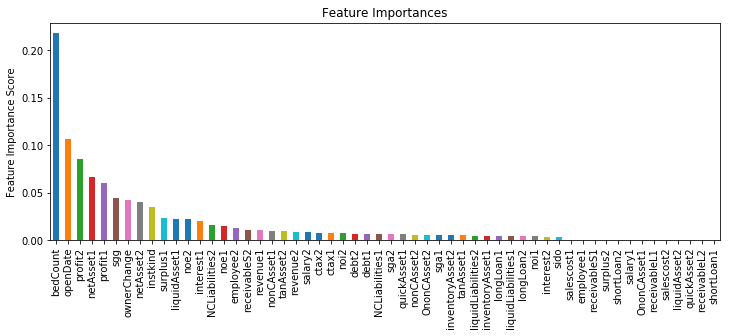

In [33]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_prod.columns if x not in [target,IDcol]]
modelfit(GBM_prod_tune, train_prod_X, predictors)

### C. Calculate the cut-off value for classification

#### Examine the optimal cut-off value (0.5~0.8 by 0.1)

In [34]:
max_accuracy = -1
coval_max = -1

for i in range(start,end):
    print('='*60)
    coval = i/10
    print(" cut-off value : " ,coval)
    print('-'*22)

    sub_GBM_tune_ths = sub_GBM_tune[['inst_id', 'OC']]
    sub_GBM_tune_ths['OC'] = [1 if oc>=coval else 0 for oc in sub_GBM_tune_ths['OC']]
    y_prod = list(sub_GBM_tune_ths['OC'])
    print(classification_report(y_true, y_prod, target_names=['open', 'close']))
    print(accuracy_score(y_true,y_prod))

    if max_accuracy < accuracy_score(y_true,y_prod):
        max_accuracy = accuracy_score(y_true,y_prod)
        coval_max = coval

 cut-off value :  0.5
----------------------
             precision    recall  f1-score   support

       open       0.57      0.31      0.40        13
      close       0.93      0.97      0.95       114

avg / total       0.89      0.91      0.89       127

0.905511811023622
 cut-off value :  0.6
----------------------
             precision    recall  f1-score   support

       open       0.70      0.54      0.61        13
      close       0.95      0.97      0.96       114

avg / total       0.92      0.93      0.92       127

0.9291338582677166
 cut-off value :  0.7
----------------------
             precision    recall  f1-score   support

       open       0.62      0.62      0.62        13
      close       0.96      0.96      0.96       114

avg / total       0.92      0.92      0.92       127

0.9212598425196851
 cut-off value :  0.8
----------------------
             precision    recall  f1-score   support

       open       0.62      0.77      0.69        13
      close 

#### Optimal cut-off value (according to 'accuracy')

In [35]:
cutoff_GBM = coval_max
cutoff_GBM

0.6

### D. Compare orginal model to tuned model

#### Defalut model
- n_estimators: default
- max_features: default
- max_depth: default
- min_sample_split: default

In [36]:
############################################################################
############ GBM
############################################################################
np.random.seed(100)
GBM_prod = GradientBoostingClassifier()
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

#### Compare 2 models with optimal cut-off value

In [37]:
sub_GBM = pd.DataFrame({'inst_id' : sub_id , 'OC' : GBM_prod_prediction })
sub_GBM = sub_GBM[['inst_id', 'OC']]
sub_GBM['OC'] = [1 if oc>=cutoff_GBM else 0 for oc in sub_GBM['OC']]
y_prod = list(sub_GBM['OC'])

In [38]:
sub_GBM_customized = sub_GBM_tune[['inst_id', 'OC']]
sub_GBM_customized['OC'] = [1 if oc >= cutoff_GBM else 0 for oc in sub_GBM_customized['OC']] # 확률값을 1,0으로 변환
y_prod_customized = list(sub_GBM_customized['OC'])

In [39]:
# Before tuned
print('============Before tuned============')
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod))
# After tuned
print('============After tuned============')
print(classification_report(y_true, y_prod_customized, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod_customized))

============Before tuned============
             precision    recall  f1-score   support

    class 0       0.80      0.92      0.86        13
    class 1       0.99      0.97      0.98       114

avg / total       0.97      0.97      0.97       127

0.968503937007874
============After tuned============
             precision    recall  f1-score   support

    class 0       0.70      0.54      0.61        13
    class 1       0.95      0.97      0.96       114

avg / total       0.92      0.93      0.92       127

0.9291338582677166


## 4. Classification Model(3) -XGBOOST
#### &nbsp;&nbsp;&nbsp;&nbsp;GBM보다 속도와 성능이 향상된 라이브러리

### A. Hyperparameter tuning of XGBOOST (using 3-fold cross validation)
- eta: The learning rate.
- num_boost_round: The number of boosting rounds

In [40]:
dtrain_prod = xgb.DMatrix(data = train_prod_X, label = train_prod_Y)
dtest_prod = xgb.DMatrix(data = test_prod_X)

#Custom error function for the XGB model
threshold = 0.5
def eval_error(preds, dtrain):
    labels = dtrain.get_label()
    preds = (preds > threshold ).astype('float')
    return "accuracy", accuracy_score(labels, preds)
    

param_tmp = {'eta': [0.1, 0.2, 0.3, 0.4]}
nrounds = 2

In [41]:
xgb_classifier = XGBClassifier(objective='binary:logistic',nthread=1)
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 42)

grid_search_XGB = GridSearchCV(xgb_classifier, param_grid = param_tmp, scoring='accuracy', n_jobs=4, cv=skf.split(train_prod_X, train_prod_Y), verbose=2)
grid_search_XGB.fit(train_prod_X, train_prod_Y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   59.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   59.2s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000207F813C620>,
       error_score='raise',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'eta': [0.1, 0.2, 0.3, 0.4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=2)

#### Check the best hyperparameter combination and train the GBM model with it

In [42]:
grid_search_XGB.best_params_

{'eta': 0.1}

In [43]:
############################################################################
############ XGBOOST - tuning
############################################################################
np.random.seed(100)
best_param = {'eta': grid_search_XGB.best_params_['eta']}

xgb_model_tune = xgb.train(best_param, 
                      dtrain_prod, 
                      num_boost_round = nrounds ,
                      feval = eval_error,
                      #maximize = True,
                      #early_stopping_rounds = 10,
                      )

XGB_prediction = xgb_model_tune.predict(dtest_prod)
sub_XGB_tune= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB_tune= sub_XGB_tune[['inst_id', 'OC']]

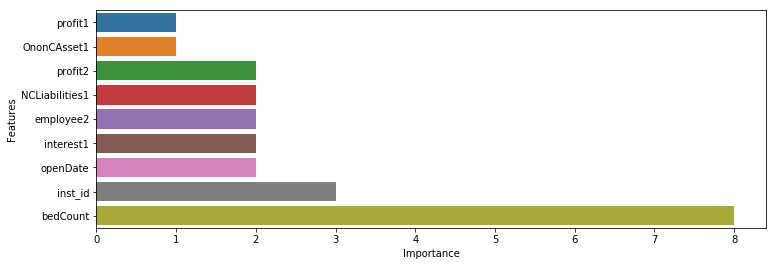

In [44]:
#PLotting the feature importance
xgb_Imp_tune = pd.DataFrame({'Features' : list(xgb_model_tune.get_score().keys()), 
                        'Importance' : list(xgb_model_tune.get_score().values())}).sort_values(['Importance'])
plt.figure()
sns.barplot(xgb_Imp_tune.Importance, xgb_Imp_tune.Features)
plt.show()

### B. Check the over-fitting of tuned model (using 5-fold cross validation)

In [45]:
# model, train, target, cross validation
np.random.seed(10)
xgb_model_tune_clf = XGBClassifier(objective='binary:logistic',
                                   learning_rate=grid_search_XGB.best_params_['eta'] )

scores = cross_val_score(xgb_model_tune_clf, train_prod_X, train_prod_Y, cv=5) 
print(scores)
print('mean : ',scores.mean())

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[0.95081967 0.95       0.95       0.95       0.95      ]
mean :  0.9501639344262296


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


## C. Calculate the cut-off value for classification

#### Examine the optimal cut-off value (0.5~0.8 by 0.1)

In [46]:
max_accuracy = -1
coval_max = -1
for i in range(start,end):
    print('='*60)
    coval = i/10
    print(" cut-off value : " ,coval)
    print('-'*22)

    sub_XGB_tune_ths = sub_XGB_tune[['inst_id', 'OC']]
    sub_XGB_tune_ths['OC'] = [1 if oc>=coval else 0 for oc in sub_XGB_tune_ths['OC']]
    y_prod = list(sub_XGB_tune_ths['OC'])
    print(classification_report(y_true, y_prod, target_names=['open', 'close']))
    acc= accuracy_score(y_true,y_prod)
    print(acc)
    if max_accuracy < acc:
        max_accuracy = acc
        coval_max = coval

 cut-off value :  0.5
----------------------
             precision    recall  f1-score   support

       open       0.80      0.92      0.86        13
      close       0.99      0.97      0.98       114

avg / total       0.97      0.97      0.97       127

0.968503937007874
 cut-off value :  0.6
----------------------
             precision    recall  f1-score   support

       open       0.10      1.00      0.19        13
      close       0.00      0.00      0.00       114

avg / total       0.01      0.10      0.02       127

0.10236220472440945
 cut-off value :  0.7
----------------------
             precision    recall  f1-score   support

       open       0.10      1.00      0.19        13
      close       0.00      0.00      0.00       114

avg / total       0.01      0.10      0.02       127

0.10236220472440945
 cut-off value :  0.8
----------------------
             precision    recall  f1-score   support

       open       0.10      1.00      0.19        13
      clos

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


#### Optimal cut-off value (according to 'accuracy')

In [47]:
cutoff_XGB = coval_max
cutoff_XGB

0.5

### D. Compare orginal model to tuned model

#### Defalut model
- eta: default

In [48]:
############################################################################
############ XGBOOST
############################################################################
XGB_prod = XGBClassifier()
XGB_prod.fit(train_prod_X, train_prod_Y)
XGB_prod_prediction = XGB_prod.predict_proba(test_prod_X)[:,1]

#### Compare 2 models with optimal cut-off value

In [49]:
sub_XGB= pd.DataFrame({'inst_id' : sub_id , 'OC' : XGB_prediction })
sub_XGB= sub_XGB[['inst_id', 'OC']]
sub_XGB['OC'] = [1 if oc>=cutoff_XGB else 0 for oc in sub_XGB['OC']]
y_prod = list(sub_XGB['OC'])

In [50]:
sub_XGB_customized = sub_XGB_tune[['inst_id', 'OC']]
sub_XGB_customized['OC'] = [1 if oc >= cutoff_XGB else 0 for oc in sub_XGB_customized['OC']] # 확률값을 1,0으로 변환
y_prod_customized = list(sub_XGB_customized['OC'])

In [51]:
# Before tuned
print('============Before tuned============')
print(classification_report(y_true, y_prod, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod))
# After tuned
print('============After tuned============')
print(classification_report(y_true, y_prod_customized, target_names=['class 0', 'class 1']))
print(accuracy_score(y_true, y_prod_customized))

============Before tuned============
             precision    recall  f1-score   support

    class 0       0.80      0.92      0.86        13
    class 1       0.99      0.97      0.98       114

avg / total       0.97      0.97      0.97       127

0.968503937007874
============After tuned============
             precision    recall  f1-score   support

    class 0       0.80      0.92      0.86        13
    class 1       0.99      0.97      0.98       114

avg / total       0.97      0.97      0.97       127

0.968503937007874


참고사이트   
1. Random forest   
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

2. GBM   
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

3. xgboost   
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/